<a href="https://colab.research.google.com/github/B571/DATA72000_ERP/blob/main/Dict/Question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import math
import numpy as np
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def text_generation(text, model, tokenizer, device, tau=0.2, known_len=50, num_iterations=100):

    # Set random seed
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Given 50 tokens of each article to generate
    input_ids = tokenizer(text, return_tensors='pt').input_ids.to(device)
    input_ids = input_ids[:,:known_len].to(device)

    # Record generated tokens and their conditional probabilities
    generated_tokens = []
    conditional_probabilities = []
    min_optimization_values = []

    # Loop to generate tokens
    for i in range(num_iterations):

        # Generate logits using the model
        with torch.no_grad():
            logits = model(input_ids).logits[:, -1, :]

        # Convert logits to probabilities
        probs = torch.softmax(logits, dim=-1)

        # Calculate negative log probabilities
        log_probs = torch.log(probs)

        # Calculate conditional entropy H(Y_t | Y_{<t} = y_{<t})
        entropy = -(probs * log_probs).sum(dim=-1)

        # Sort tokens by probability
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

        # Find the index where cumulative probability mass reaches τ
        cutoff_index = torch.where(cumulative_probs >= tau)[1][0]

        # Select the truncated set C(y_<t)
        truncated_probs = sorted_probs[:, :cutoff_index + 1]
        truncated_indices = sorted_indices[:, :cutoff_index + 1]

        # Calculate (log_prob + entropy) for each candidate token
        optimization_values = log_probs[0, truncated_indices] + entropy

        # Calculate the cumulative sum of these values
        cumulative_optimization_value = optimization_values.sum().item()

        # Record the minimized cumulative sum
        min_optimization_values.append(cumulative_optimization_value)

        # Sample from the truncated distribution
        sample_index = torch.multinomial(truncated_probs, num_samples=1)

        # Get the token ID and its corresponding word
        next_token_id = truncated_indices[:, sample_index].squeeze()

        # Store the generated token
        next_token = tokenizer.decode(next_token_id.item())
        generated_tokens.append(next_token)
        conditional_probabilities.append(probs[0, next_token_id].item())

        # Adjust the dimension of next_token_id for concatenation
        next_token_id = next_token_id.unsqueeze(0).unsqueeze(0)

        # Update the input context
        input_ids = torch.cat([input_ids, next_token_id], dim=1).to(device)

    # Combine the generated tokens into a sentence
    combined_string = " ".join(generated_tokens)

    # Calculate the average information content 𝐼 = 𝑙𝑜𝑔 (𝑝(𝑦)) / T
    # Convert conditional probabilities to NumPy array
    conditional_probabilities_np = np.array(conditional_probabilities)

    # Calculate the cumulative product of elements in the NumPy array
    cumulative_product = np.prod(conditional_probabilities_np)

    # Calculate average information content
    ave_I = math.log(cumulative_product,2)/100

    return combined_string, ave_I

In [ ]:
# Load test_df
file_path = "/content/drive/MyDrive/Colab Notebooks/output_csv/test_df.csv"
df = pd.read_csv(file_path)

In [ ]:
# Load model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/results") #/content/drive/MyDrive/Colab Notebooks/results
model = GPT2LMHeadModel.from_pretrained("/content/drive/MyDrive/Colab Notebooks/results").to('cuda')

In [ ]:
num_iterations = 100

# Create a new empty column in test_df to store the text and Cumulative sum of log(p(y))
df["generated_tokens"] = ""
df["ave_I"] = 0.01
print(df.head())
print(df.shape)


        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

  generated_tokens  ave_I  
0                    0.01  
1                    0.01  
2                    0.01  
3                    0.01  
4                    0.01  
(2952, 6)


In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

import time

# Rcord start time
start_time = time.time()

for index, row in df.iterrows():
  print("article index",index)
  text = row["Article text"]
  combined_string, ave_I = text_generation(text, model, tokenizer, device='cuda')
  # print("combined_string:", combined_string)
  print("ave_I", ave_I)
  df.loc[index, "generated_tokens"] = combined_string
  df.loc[index, "ave_I"] = ave_I

# Rcord ending time
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time/60} minutes")

# print("generated_tokens:", combined_string)
# print("ave_I", ave_I)

article index 0
ave_I -1.9898689810327428
article index 1


Token indices sequence length is longer than the specified maximum sequence length for this model (1134 > 1024). Running this sequence through the model will result in indexing errors


流式输出内容被截断，只能显示最后 5000 行内容。
ave_I -1.3773460843574241
article index 453
ave_I -1.87175739665696
article index 454
ave_I -1.5112466783132061
article index 455
ave_I -1.335129345760686
article index 456
ave_I -1.8722825622662602
article index 457
ave_I -2.285163285144918
article index 458
ave_I -1.1535080976323537
article index 459
ave_I -1.9669442030936524
article index 460
ave_I -1.5396671221134173
article index 461
ave_I -1.7798266284068034
article index 462
ave_I -1.7800221992582024
article index 463
ave_I -1.6912037627401042
article index 464
ave_I -1.942059638987686
article index 465
ave_I -1.2214076429614604
article index 466
ave_I -1.675791753090965
article index 467
ave_I -1.7178427070255307
article index 468
ave_I -0.7161685443338226
article index 469
ave_I -0.9610083877205311
article index 470
ave_I -1.6412470428986234
article index 471
ave_I -1.4780228098247894
article index 472
ave_I -1.338075303868901
article index 473
ave_I -2.225426372626595
article index 474
ave_I -1.4513

In [ ]:
print(df.head())
df.to_csv("/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_generation_RAN.csv", index=True)

        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

                                    generated_tokens     ave_I  
0   has  been  forced  to  flee  their  homes  in... -1.989869  
1   team  said  it  would  " continue  to  work  ... -1.091827  
2  ,  the  attorneys  general ,  state  attorneys... -1.949087  
3   millions  of  people . \n \n You

In [ ]:
df_log = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_generation_RAN.csv")
print(df_log.head())

   Unnamed: 0       Date published  Category  \
0           0  2021-12-13 02:05:22      news   
1           1  2021-12-08 15:24:55     sport   
2           2  2021-06-14 17:03:00  business   
3           3  2021-02-10 12:48:36     sport   
4           4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

                                    generated_tokens     ave_I  
0   has  been  forced  to  flee  their  homes  in... -1.989869  
1   team  said  it  would  " continue  to  work  ... -1.091827  
2  ,  the  attorneys  general

## **EDA of average information content**

In [ ]:
print(df_log['ave_I'].describe())

count    2952.000000
mean       -1.498521
std         0.457112
min        -2.703846
25%        -1.849379
50%        -1.516819
75%        -1.175762
max        -0.169135
Name: ave_I, dtype: float64


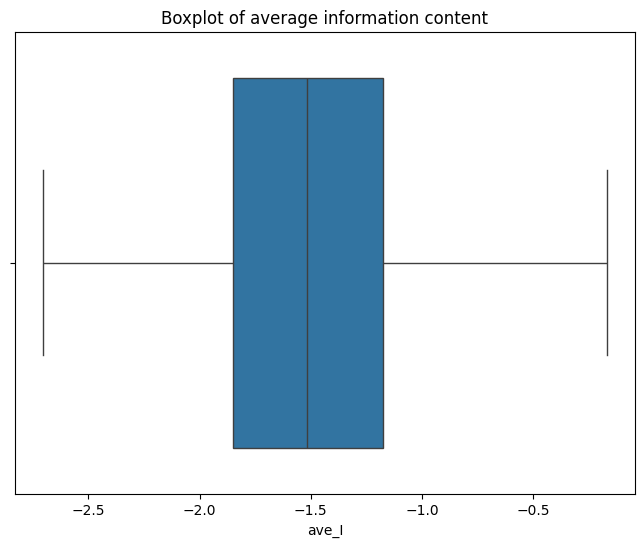

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt # Import the matplotlib library
import seaborn as sns

# Visualize the distribution of the data (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_log['ave_I'])
plt.title('Boxplot of average information content')
plt.show()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/word_count_boxplot_RAN.png')

In [ ]:
# Check for outliers (based on the boxplot rule: 1.5 times IQR)
Q1 = df_log['ave_I'].quantile(0.25)
Q3 = df_log['ave_I'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower_bound",lower_bound, "IQR", IQR, "upper_bound", upper_bound)

outliers = df_log[(df_log['ave_I'] < lower_bound) | (df_log['ave_I'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
print(Q1,Q3)

lower_bound -2.8598045026383527 IQR 0.6736170368984145 upper_bound -0.1653363550446949
Number of outliers: 0
-1.8493789472907312 -1.1757619103923167


The x coordinate of the KDE peak is: -1.5291000251501228
The skewness of the data is: 0.18
The kurtosis of the data is: -0.42


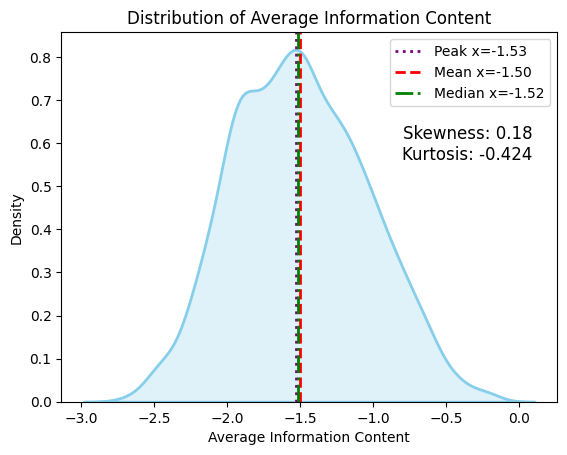

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, skew, kurtosis, norm

data = df_log['ave_I']

# Create a KDE object
kde = gaussian_kde(data)

# Generate a series of points on the x-axis
x_vals = np.linspace(data.min(), data.max(), 1000)

# Calculate the KDE values at these points
kde_values = kde(x_vals)

# Find the peak of the KDE function
max_kde_index = np.argmax(kde_values)
peak_x = x_vals[max_kde_index]

# Calculate the skewness and kurtosis of the data
data_skewness = skew(data)
data_kurtosis = kurtosis(data, fisher=True)  # Fisher's definition: subtract 3 to compare to normal distribution

# Print the skewness and kurtosis
print(f"The x coordinate of the KDE peak is: {peak_x}")
print(f"The skewness of the data is: {data_skewness:.2f}")
print(f"The kurtosis of the data is: {data_kurtosis:.2f}")

# Visualize the distribution and peak location
sns.kdeplot(data, fill=True, color='skyblue', linewidth=2)
plt.axvline(x=peak_x, color='purple', linestyle=':', linewidth=2, label=f'Peak x={peak_x:.2f}')

# Add vertical lines
x1 = data.mean()
x2 = data.median()
plt.axvline(x=x1, color='red', linestyle='--', linewidth=2, label=f'Mean x={x1:.2f}')
plt.axvline(x=x2, color='green', linestyle='-.', linewidth=2, label=f'Median x={x2:.2f}')

# Add label and title
plt.title('Distribution of Average Information Content')
plt.xlabel('Average Information Content')
plt.ylabel('Density')

# Add skewness and kurtosis to figure
plt.text(0.95, 0.75, f'Skewness: {data_skewness:.2f}\nKurtosis: {data_kurtosis:.3f}',
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes,
         fontsize=12, color='black')

plt.legend()
plt.show()


-1.5291000251501228


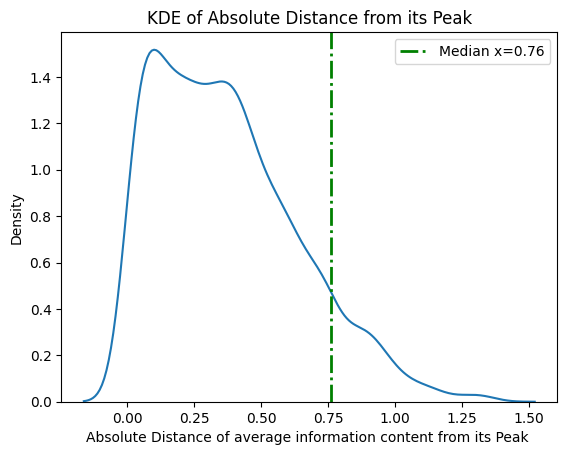

Proportion of data with absolute distance less than 0.76: 90.92%


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

center = peak_x
print(center)
df_log['distance'] = np.abs(df_log['ave_I'] - center)

# Plot the Kernel Density Estimate (KDE) graph
sns.kdeplot(df_log['distance'])
plt.axvline(x=0.76, color='green', linestyle='-.', linewidth=2, label=f'Median x={0.76:.2f}')
plt.xlabel('Absolute Distance of average information content from its Peak')
plt.ylabel('Density')
plt.title('KDE of Absolute Distance from its Peak')

plt.legend()
plt.show()

# Calculate the proportion of data with an absolute distance less than 0.76 from the center
threshold = 0.76
proportion = (df_log['distance'] < threshold).sum() / len(df_log)

print(f"Proportion of data with absolute distance less than {threshold}: {proportion:.2%}")



In [ ]:
average = (peak_x + x1 + x2)/3
print(average)
for center in [peak_x, x1, x2, average]:
  df_log['distance'] = np.abs(df_log['ave_I'] - center)
  proportion = (df_log['distance'] < threshold).sum() / len(df_log)
  std = df_log['distance'].std()
  print(f"Proportion of data centered at {center} with absolute distance less than {threshold}: {proportion:.2%}")
  print(f"Standard deviation of data centered at {center} with absolute distance less than {threshold}: {std:.2f}")

-1.5148132773328664
Proportion of data centered at -1.5291000251501228 with absolute distance less than 0.76: 90.92%
Standard deviation of data centered at -1.5291000251501228 with absolute distance less than 0.76: 0.27
Proportion of data centered at -1.498521257667416 with absolute distance less than 0.76: 91.02%
Standard deviation of data centered at -1.498521257667416 with absolute distance less than 0.76: 0.26
Proportion of data centered at -1.5168185491810602 with absolute distance less than 0.76: 90.96%
Standard deviation of data centered at -1.5168185491810602 with absolute distance less than 0.76: 0.27
Proportion of data centered at -1.5148132773328664 with absolute distance less than 0.76: 91.12%
Standard deviation of data centered at -1.5148132773328664 with absolute distance less than 0.76: 0.27


## **Categorical discussion**

In [ ]:
# Create a new dataframe to store data
summary_df_log = pd.DataFrame(columns=['Category', 'Length', 'Mean', 'Standard Deviation', 'Epsilon'])

mean = df_log['ave_I'].mean()
sd = df_log['ave_I'].std()
epsilon = (df_log['ave_I']-mean).abs().max()
length = len(df_log)

category = "total"

# Add result to summary_df
summary_df_log.loc[0] = [category, length, mean, sd, epsilon]

In [ ]:
# Calculate the data for each group
category_groups = df_log.groupby('Category')

index = 1

for category, group in category_groups:
    # print(f"Category: {category}")
    length = len(group)
    mean = group['ave_I'].mean()
    sd = group['ave_I'].std()
    epsilon = (group['ave_I']-mean).abs().max()

    # Add result to summary_df
    summary_df_log.loc[index] = [category, length, mean, sd, epsilon]
    index += 1

print(summary_df_log)

        Category  Length      Mean  Standard Deviation   Epsilon
0          total    2952 -1.498521            0.457112  1.329386
1       business      75 -1.516634            0.422601  0.914898
2  entertainment      43 -1.571714            0.566821  1.375424
3         health      19 -1.643420            0.354376  0.649687
4           news    1112 -1.544276            0.441369  1.375140
5       politics      46 -1.583386            0.381838  0.882081
6          sport    1657 -1.461079            0.465616  1.271500


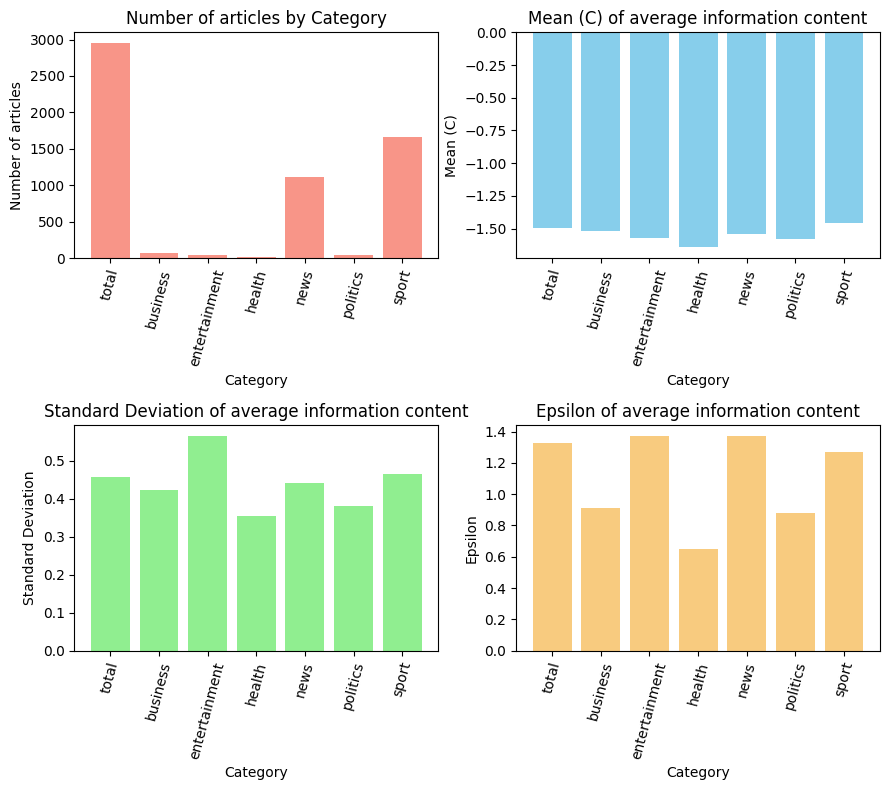

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(9, 8))

# Rotation angle for x-axis labels
rotation = 75

# First subplot: Histogram of 'Length' column data
plt.subplot(2, 2, 1)
plt.bar(summary_df_log['Category'], summary_df_log['Length'], color='#f89588')
plt.xlabel('Category')
plt.ylabel('Number of articles')
plt.title('Number of articles by Category')
plt.xticks(rotation=rotation)  # Rotate x-axis labels if they are too long

# Second subplot: Histogram of 'Mean' column data
plt.subplot(2, 2, 2)
plt.bar(summary_df_log['Category'], summary_df_log['Mean'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Mean (C)')
plt.title('Mean (C) of average information content')
plt.xticks(rotation=rotation)  # Rotate x-axis labels if they are too long

# Third subplot: Histogram of 'Standard Deviation' column data
plt.subplot(2, 2, 3)
plt.bar(summary_df_log['Category'], summary_df_log['Standard Deviation'], color='lightgreen')
plt.xlabel('Category')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of average information content')
plt.xticks(rotation=rotation)

# Fourth subplot: Histogram of 'Epsilon' column data
plt.subplot(2, 2, 4)
plt.bar(summary_df_log['Category'], summary_df_log['Epsilon'], color='#f8cb7f')
plt.xlabel('Category')
plt.ylabel('Epsilon')
plt.title('Epsilon of average information content')
plt.xticks(rotation=rotation)

# Adjust layout to prevent overlapping plots
plt.tight_layout()

# Show the plot
plt.show()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/average_information_data_RAN.png")


## **Calculate MAUVE score of generated text**

In [ ]:
# install mauve in google colab
!pip install mauve-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 83.6 MB/s eta 0:00:00


In [ ]:
# Define the MAUVE computation function
def compute_mauve(generated_texts, reference_texts):
    mauve_result = mauve.compute_mauve(
        p_text=generated_texts,
        q_text=reference_texts
    )
    return mauve_result.mauve

In [ ]:
# Define a function to tokenize the text, select the first 150 tokens, and then convert it back to text
def process_text(text):
    tokenizer = GPT2Tokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/results")

    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Select tokens 50 to 150
    selected_tokens = tokens[50:151]

    # Convert these tokens back to text
    processed_text = tokenizer.convert_tokens_to_string(selected_tokens)

    return processed_text


In [ ]:
reference_texts = df["Article text"].apply(process_text).tolist()
generated_texts = df["generated_tokens"].tolist()

In [ ]:
import mauve

# Calculate MAUVE score
mauve_score = compute_mauve(df.loc[:2, "generated_tokens"], df.loc[:2, "Article text"].apply(process_text))
print(f"MAUVE Score: {mauve_score}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Featurizing p:   0%|          | 0/3 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3 [00:00<?, ?it/s]

MAUVE Score: 0.004072096261961256


## **Calculate Perplexity of generated text**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
def calculate_perplexity(text):
    tokens = tokenizer.encode(text, return_tensors="pt").to(device)
    input_ids = torch.tensor(tokens).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(tokens, labels=tokens)
    loss = outputs.loss.item()
    perplexity = torch.exp(torch.tensor(loss))
    return perplexity.item()

# Calxulate perplexity and store in DataFrame
df['perplexity_generated'] = df['generated_tokens'].apply(calculate_perplexity)
df['perplexity_reference'] = df["Article text"].apply(process_text).apply(calculate_perplexity)

<ipython-input-51-bd78a384f5b6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(tokens).unsqueeze(0).to(device)
<ipython-input-51-bd78a384f5b6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(tokens).unsqueeze(0).to(device)


In [ ]:
print(df['perplexity_generated'].describe())
print("\n", df['perplexity_reference'].describe())
print(df['perplexity_generated'].median())

count    2952.000000
mean        8.172451
std         4.989919
min         1.346633
25%         4.861630
50%         7.310751
75%        10.285911
max       101.308105
Name: perplexity_generated, dtype: float64

 count    2952.000000
mean       36.976612
std        16.749180
min         6.010852
25%        25.858487
50%        33.445250
75%        44.180505
max       198.262573
Name: perplexity_reference, dtype: float64
7.310750722885132


In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_generation_metrics_RAN.csv", index=True)
print(df.head())

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_generation_metrics_RAN.csv")

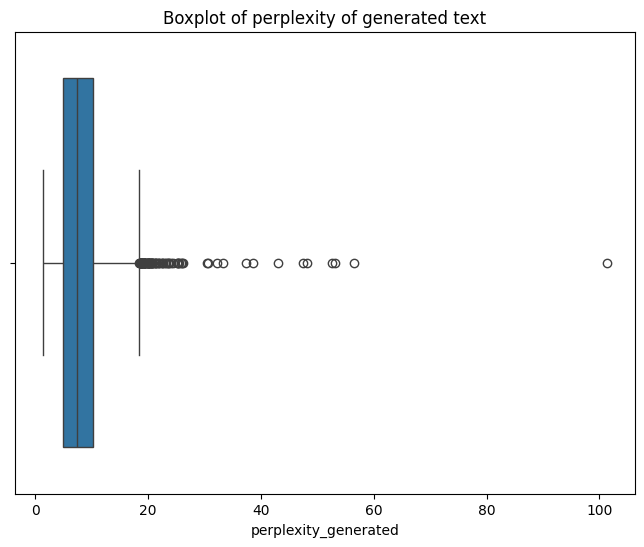

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the distribution of the data (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['perplexity_generated'])
plt.title('Boxplot of perplexity of generated text')
plt.show()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/word_count_boxplot_RAN.png')

In [ ]:
# Check for outliers (based on the boxplot rule: 1.5 times IQR)
Q1 = df['perplexity_generated'].quantile(0.25)
Q3 = df['perplexity_generated'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower_bound",lower_bound, "IQR", IQR, "upper_bound", upper_bound)

outliers = df[(df['perplexity_generated'] < lower_bound) | (df['perplexity_generated'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
print(Q1,Q3)

lower_bound -3.2747920751571655 IQR 5.424281358718872 upper_bound 18.422333359718323
Number of outliers: 82
4.861629962921143 10.285911321640015


In [ ]:
# Check for outliers (based on the boxplot rule: 1.5 times IQR)
Q1 = df['perplexity_reference'].quantile(0.25)
Q3 = df['perplexity_reference'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower_bound",lower_bound, "IQR", IQR, "upper_bound", upper_bound)

outliers = df[(df['perplexity_reference'] < lower_bound) | (df['perplexity_reference'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
print(Q1,Q3)

lower_bound -1.6245405673980713 IQR 18.322018146514893 upper_bound 71.6635320186615
Number of outliers: 115
25.858486652374268 44.18050479888916


## **Calculate n-gram diversity D of generated text**

In [ ]:
from nltk import ngrams
from collections import Counter, defaultdict

def ngram_metrics(token_list, pad=1):
    if pad in token_list:
        token_list = token_list[:token_list.index(pad)]  # Remove possible padding
    stats = defaultdict(float)
    for n in range(1, 5):
        ngs = [ng for ng in ngrams(token_list, n)]
        counter = Counter([ng for ng in ngrams(token_list, n)])
        stats['pct_repeat_%dgrams' % n] = 1.0 - len(counter) / len(ngs)
    return stats

In [ ]:
# Restore the aggregate_ngram_metrics function
def aggregate_ngram_metrics(token_list, pad=1):
    metrics = ngram_metrics(token_list)
    total_percentage = np.mean([v for k, v in metrics.items() if 'pct_repeat' in k])
    return total_percentage

In [ ]:
df['ngram_generated'] = np.zeros(len(df))
df['ngram_reference'] = np.zeros(len(df))

for index in range(len(df)):
  print(index)

  generated_text = df.loc[index, 'generated_tokens'].split()
  df.loc[index, 'ngram_generated'] = aggregate_ngram_metrics(generated_text)

  reference_text = reference_texts[index].split()
  df.loc[index, 'ngram_reference'] = aggregate_ngram_metrics(reference_text)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_generation_metrics_RAN.csv", index=True)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_generation_metrics_RAN.csv")

print(df['ngram_generated'].describe())
print("\n", df['ngram_reference'].describe())

count    2952.000000
mean        0.417175
std         0.194229
min         0.066405
25%         0.258129
50%         0.406249
75%         0.555005
max         0.959386
Name: ngram_generated, dtype: float64

 count    2952.000000
mean        0.053529
std         0.018627
min         0.004808
25%         0.042208
50%         0.051242
75%         0.061806
max         0.314438
Name: ngram_reference, dtype: float64


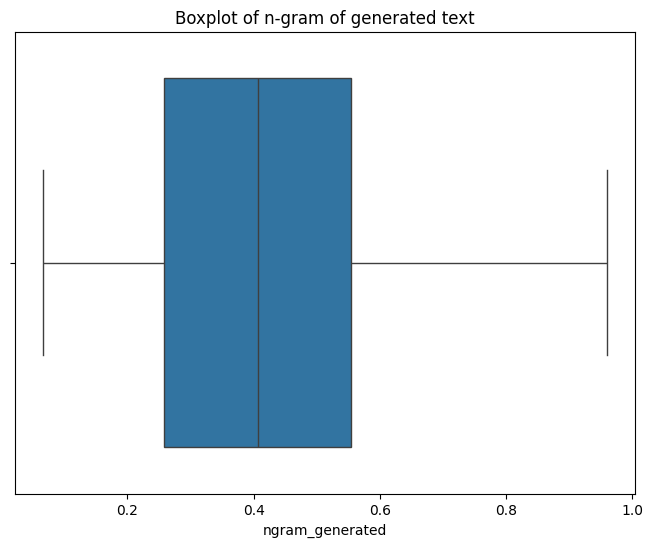

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the distribution of the data (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['ngram_generated'])
plt.title('Boxplot of n-gram of generated text')
plt.show()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/word_count_boxplot_RAN.png')

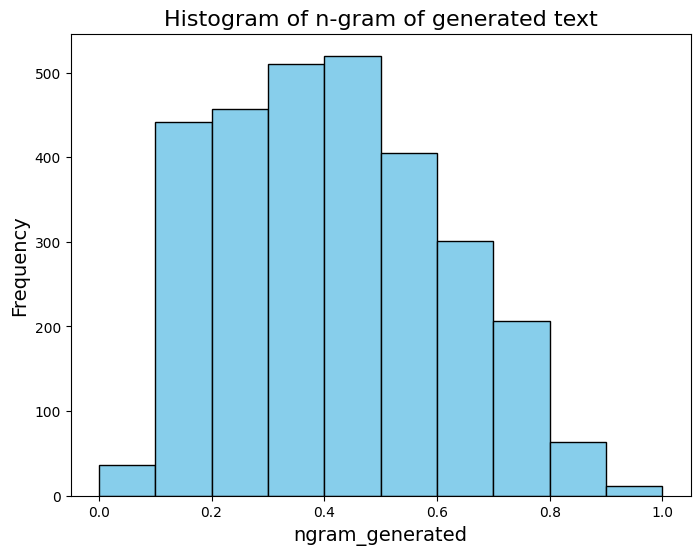

In [ ]:

plt.figure(figsize=(8, 6))
plt.hist(df['ngram_generated'], bins=np.linspace(0, 1, 11), color='skyblue', edgecolor='black')

plt.title('Histogram of n-gram of generated text', fontsize=16)
plt.xlabel('ngram_generated', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()

In [ ]:
# Check for outliers (based on the boxplot rule: 1.5 times IQR)
Q1 = df['ngram_generated'].quantile(0.25)
Q3 = df['ngram_generated'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower_bound",lower_bound, "IQR", IQR, "upper_bound", upper_bound)

outliers = df[(df['ngram_generated'] < lower_bound) | (df['ngram_generated'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
print(Q1,Q3)

lower_bound -0.18718521367563484 IQR 0.2968762374377671 upper_bound 1.0003197360754335
Number of outliers: 0
0.25812914248101576 0.5550053799187828


In [ ]:
# Check for outliers (based on the boxplot rule: 1.5 times IQR)
Q1 = df['ngram_reference'].quantile(0.25)
Q3 = df['ngram_reference'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower_bound",lower_bound, "IQR", IQR, "upper_bound", upper_bound)

outliers = df[(df['ngram_reference'] < lower_bound) | (df['ngram_reference'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
print(Q1,Q3)

lower_bound 0.012811147186146989 IQR 0.019597763347763406 upper_bound 0.0912022005772006
Number of outliers: 87
0.0422077922077921 0.0618055555555555


## **Calculate Zipf’s coefficient of generated text**

In [ ]:
from collections import Counter

def calculate_zipf_coefficient(text):
    words = text.split()
    word_freq = Counter(words)
    sorted_freq = sorted(word_freq.values(), reverse=True)

    ranks = np.arange(1, len(sorted_freq) + 1)
    freqs = np.array(sorted_freq)

    log_ranks = np.log(ranks)
    log_freqs = np.log(freqs)

    # Calculate the slope through linear regression, which is the Zipf coefficient
    slope, _ = np.polyfit(log_ranks, log_freqs, 1)
    return -slope

# Calculate the Zipf coefficient of the generated text and add it to the DataFrame
df['zipf_coefficient_generated'] = df['generated_tokens'].apply(calculate_zipf_coefficient)
df['zipf_coefficient_reference'] = df["Article text"].apply(process_text).apply(calculate_zipf_coefficient)

In [ ]:
print(df['zipf_coefficient_generated'].describe())
print("\n", df['zipf_coefficient_reference'].describe())

count    2.952000e+03
mean     6.885331e-01
std      2.000890e-01
min     -3.664581e-16
25%      5.671544e-01
50%      6.462011e-01
75%      7.685261e-01
max      3.215808e+00
Name: zipf_coefficient_generated, dtype: float64

 count    2952.000000
mean        0.318825
std         0.061646
min         0.052246
25%         0.279142
50%         0.318379
75%         0.358214
max         0.567785
Name: zipf_coefficient_reference, dtype: float64


In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_generation_metrics_RAN.csv", index=True)
print(df.head())

   Unnamed: 0       Date published  Category  \
0           0  2021-12-13 02:05:22      news   
1           1  2021-12-08 15:24:55     sport   
2           2  2021-06-14 17:03:00  business   
3           3  2021-02-10 12:48:36     sport   
4           4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

                                    generated_tokens     ave_I  \
0   has  been  forced  to  flee  their  homes  in... -1.989869   
1   team  said  it  would  " continue  to  work  ... -1.091827   
2  ,  the  attorneys  gene

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_generation_metrics.csv")

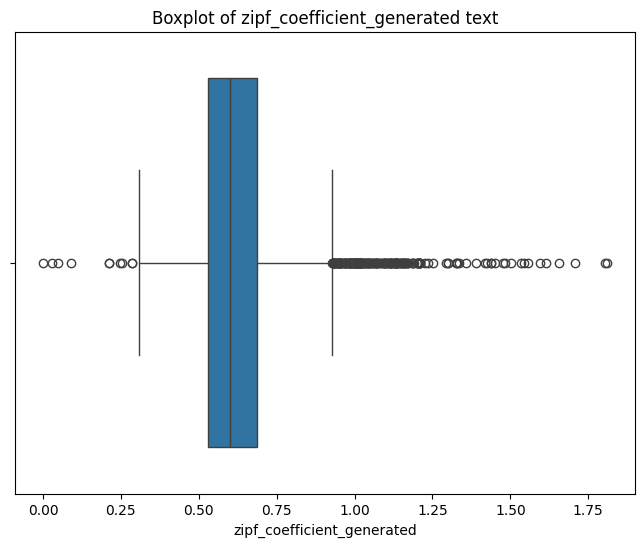

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the distribution of the data (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['zipf_coefficient_generated'])
plt.title('Boxplot of zipf_coefficient_generated text')
plt.show()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/word_count_boxplot.png')

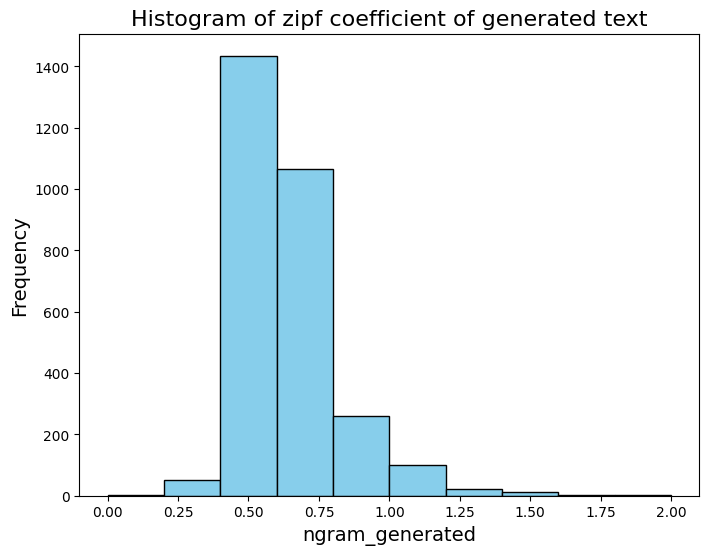

In [ ]:

plt.figure(figsize=(8, 6))
plt.hist(df['zipf_coefficient_generated'], bins=np.linspace(0, 2, 11), color='skyblue', edgecolor='black')

plt.title('Histogram of zipf coefficient of generated text', fontsize=16)
plt.xlabel('ngram_generated', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()

In [ ]:
# Check for outliers (based on the boxplot rule: 1.5 times IQR)
Q1 = df['zipf_coefficient_generated'].quantile(0.25)
Q3 = df['zipf_coefficient_generated'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower_bound",lower_bound, "IQR", IQR, "upper_bound", upper_bound)

outliers = df[(df['zipf_coefficient_generated'] < lower_bound) | (df['zipf_coefficient_generated'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
print(Q1,Q3)

lower_bound 0.2650969269022984 IQR 0.2013716667218891 upper_bound 1.070583593789855
Number of outliers: 160
0.5671544269851321 0.7685260937070212


In [ ]:
# Check for outliers (based on the boxplot rule: 1.5 times IQR)
Q1 = df['zipf_coefficient_reference'].quantile(0.25)
Q3 = df['zipf_coefficient_reference'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower_bound",lower_bound, "IQR", IQR, "upper_bound", upper_bound)

outliers = df[(df['zipf_coefficient_reference'] < lower_bound) | (df['zipf_coefficient_reference'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
print(Q1,Q3)

lower_bound 0.16053514232856092 IQR 0.07907136259385505 upper_bound 0.47682059270398114
Number of outliers: 38
0.2791421862193435 0.35821354881319856
